# Optimization - CEM / ES

<img src="https://raw.githubusercontent.com/jeremiedecock/polytechnique-inf581-2024-students/main/logo.jpg" style="float: left; width: 15%" />

[INF581-2024](https://moodle.polytechnique.fr/course/view.php?id=17108) Lab session #7

2019-2024 Jérémie Decock

[![Open in Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeremiedecock/polytechnique-inf581-2024-students/blob/main/lab7_optim.ipynb)

[![My Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/jeremiedecock/polytechnique-inf581-2024-students/main?filepath=lab7_optim.ipynb)

[![NbViewer](https://raw.githubusercontent.com/jupyter/design/main/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/jeremiedecock/polytechnique-inf581-2024-students/blob/main/lab7_optim.ipynb)

[![Local](https://img.shields.io/badge/Local-Save%20As...-blue)](https://github.com/jeremiedecock/polytechnique-inf581-2024-students/raw/main/lab7_optim.ipynb)


## Introduction

In the previous lab we studied a method that allowed us to apply reinforcement learning in continuous state spaces and/or continuous action spaces.
We used REINFORCE, a *Policy gradient* method that directly optimize the parametric policy $\pi_{\theta}$.
The parameter $\theta$ was iteratively updated toward a local maximum of the total expected reward $J(\theta)$ using a gradient ascent method:
$$\theta \leftarrow \theta + \alpha \nabla_{\theta}J(\theta)$$
A convenient analytical formulation of $\nabla_{\theta}J(\theta)$ was obtained thanks to the *Policy Gradient theorem*:

$$\nabla_\theta J(\theta) = \nabla_\theta V^{\pi_\theta}(s) = \mathbb{E}_{\pi_\theta} \left[\nabla_\theta \log \pi_\theta (s,a) Q^{\pi_\theta}(s,a) \right].$$
However, gradient ascent methods may have a slow convergence and will only found a local optimum.
Moreover, this approach requires an analytical formulation of $\nabla_\theta \log \pi_\theta (s,a)$ which is not always known (when something else than a neural networks is used for the agent's policy).

Direct Policy Search methods using gradient free optimization procedures like Evolution Strategies or Cross Entropy Method (CEM) are interesting alternatives to Policy Gradient algorithms.
They can be successfully applied as long as the $\pi_\theta$ policy has no more than few hundreds of parameters.
Moreover, these method can solve complex problems that cannot be modeled as Markov Decision Processes.

As for previous Reinforcement Learning labs, we will use standard problems provided by Gymnasium suite.
Especially, we will try to solve the LunarLander-v2 problem (https://gymnasium.farama.org/environments/box2d/lunar_lander/) which offers both continuous space and action states.

As for previous labs, you can either:
- open, edit and execute the notebook in *Google Colab* following this link: https://colab.research.google.com/github/jeremiedecock/polytechnique-inf581-2024-students/blob/main/lab7_optim.ipynb ; this is the **recommended** choice as you have nothing to install on your computer
- open, edit and execute the notebook in *MyBinder* (if for any reason the Google Colab solution doesn't work): https://mybinder.org/v2/gh/jeremiedecock/polytechnique-inf581-2024-students/main?filepath=lab7_optim.ipynb
- download, edit and execute the notebook on your computer if Python3 and JypyterLab are already installed: https://github.com/jeremiedecock/polytechnique-inf581-2024-students/raw/main/lab7_optim.ipynb

If you work with Google Colab or MyBinder, **remember to save or download your work regularly or you may lose it!**

## Name your work

Replace the values in the following dictionary `info`. Your Email must match your class email address. Your Alias will be shown on the public leaderboard (to identify yourself).

In [2]:
info = {
        'Email' : 'abdoul.zeba@polytechnique.edu',
        'Alias' : 'Tokic', # (change this in case you want to identify yourself on the leaderboard)
}

## Setup the Python environment

This notebook relies on several libraries including `gymnasium`, `numpy`, `pandas`, `seaborn`, `imageio`, `pygame` and `cma`.
A complete list of dependencies can be found in the provided [requirements-lab7.txt](https://raw.githubusercontent.com/jeremiedecock/polytechnique-inf581-2024-students/master/requirements-lab7.txt) file.

### If you use Google Colab

Execute the next cell to install required libraries.

In [3]:
import sys, subprocess

def is_colab():
    return "google.colab" in sys.modules

def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())

if is_colab():
    run_subprocess_command("apt install swig xvfb x11-utils")
    run_subprocess_command("pip install gymnasium[box2d] pyvirtualdisplay cma")

In [4]:
#! apt install xvfb x11-utils && pip install gymnasium pyvirtualdisplay

### If you have downloaded the notebook on your computer and execute it in your own Python environment

To set up the necessary dependencies, first download the [requirements-lab7.txt](https://raw.githubusercontent.com/jeremiedecock/polytechnique-inf581-2024-students/master/requirements-lab7.txt) file and ensure it is located in the same directory as this notebook. Next, run the following command to establish a [Python virtual environment (venv)](https://docs.python.org/3/library/venv.html) that includes all the essential libraries for this lab.

#### On Posix systems (Linux, MacOSX, WSL, ...)

```bash
deactivate
python3 -m venv env-lab7
source env-lab7/bin/activate
python3 -m pip install --upgrade pip
python3 -m pip install -r requirements-lab7.txt
```

#### On Windows

```bash
deactivate
python3 -m venv env-lab7
env\Scripts\activate.bat
python3 -m pip install --upgrade pip
python3 -m pip install -r requirements-lab7.txt
```

### Run INF581 notebooks locally in a dedicated Docker container

If you are familiar with Docker, an image is available on Docker Hub for this lab:

```bash
docker run -it --rm -p 8888:8888 -v "${PWD}":/home/jovyan/work jdhp/inf581-lab7:latest
```

If you encounter an error during the notebook's execution indicating that writing a file is not possible, this issue may stem from the user ID within the container lacking the necessary permissions in the project directory. This problem can be resolved by modifying the directory's permissions, for example, using the command:

```bash
chmod 777 .
rm lab7_*.gif
rm lab7_*.png
rm *.pth
```

### Import required packages

In [5]:
import gymnasium as gym
import math
import numpy as np
from numpy.typing import NDArray
import pandas as pd
import itertools
import json
import time
from typing import List, Tuple, Deque, Optional, Callable

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt

import seaborn as sns
#from tqdm.notebook import tqdm

In [7]:
gym.__version__

'0.29.1'

In [8]:
sns.set_context("talk")

### Create a Gymnasium rendering wrapper to visualize environments as GIF images within the notebook

In [9]:
# To display GIF images in the notebook

import imageio     # To render episodes in GIF images (otherwise there would be no render on Google Colab)
                   # C.f. https://stable-baselines.readthedocs.io/en/master/guide/examples.html#bonus-make-a-gif-of-a-trained-agent
import IPython
from IPython.display import Image

if is_colab():
    import pyvirtualdisplay

    _display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                        size=(1400, 900))
    _ = _display.start()

class RenderWrapper:
    def __init__(self, env, force_gif=False):
        self.env = env
        self.force_gif = force_gif
        self.reset()

    def reset(self):
        self.images = []

    def render(self):
        if not is_colab():
            self.env.render()
            time.sleep(1./60.)

        if is_colab() or self.force_gif:
            img = self.env.render()         # Assumes env.render_mode == 'rgb_array'
            self.images.append(img)

    def make_gif(self, filename="render"):
        if is_colab() or self.force_gif:
            imageio.mimsave(filename + '.gif', [np.array(img) for i, img in enumerate(self.images) if i%2 == 0], fps=29, loop=0)
            return Image(open(filename + '.gif','rb').read())

    @classmethod
    def register(cls, env, force_gif=False):
        env.render_wrapper = cls(env, force_gif=True)

## Exercise 1: Implement CEM and test it on the CartPole environment

Before solving the Lunar Lander environment, we will practice on the (simpler) CartPole environment.

**Reminder**: a description of the CartPole environment is available at https://gymnasium.farama.org/environments/classic_control/cart_pole/. This environment offers a continuous state space and discrete action space.

An implementation of the CartPole policy is given in the following cell.

In [10]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


def logistic_regression(s, theta):
    prob_push_right = sigmoid(np.dot(s, np.transpose(theta)))
    return prob_push_right


def draw_action(s, theta):
    prob_push_right = logistic_regression(s, theta)
    r = np.random.rand()
    return 1 if r < prob_push_right else 0


# Logistic Regression ############################################

class LogisticRegression:

    def __init__(self, env):
        self.num_params = env.observation_space.shape[0]

    def __call__(self, state, theta):
        return draw_action(state, theta)

Optimization algorithms aim to find the minimum of a function. This function is called an "objective function".
The cell below implements the framework for such a function.
Note that in reinforcement learning, by convention the score is a reward to maximize whereas in mathematical optimization the score is a cost to minimize (most optimization libraries like PyCMA used in this lab impose this convention) ; the objective function will therefore return the opposite of the reward as the score of evaluated policies.

In [11]:
class ObjectiveFunction:

    def __init__(self, env, policy, num_episodes=1, max_time_steps=float('inf'), minimization_solver=True):
        self.ndim = policy.num_params  # Number of dimensions of the parameter (weights) space
        self.env = env
        self.policy = policy
        self.num_episodes = num_episodes
        self.max_time_steps = max_time_steps
        self.minimization_solver = minimization_solver

        self.num_evals = 0


    def eval(self, policy_params, num_episodes=None, max_time_steps=None, render=False):
        """Evaluate a policy"""

        self.num_evals += 1

        if num_episodes is None:
            num_episodes = self.num_episodes

        if max_time_steps is None:
            max_time_steps = self.max_time_steps

        average_total_rewards = 0

        for i_episode in range(num_episodes):

            total_rewards = 0.
            state, info = self.env.reset()

            for t in range(max_time_steps):
                if render:
                    self.env.render_wrapper.render()

                action = self.policy(state, policy_params)
                state, reward, done, truncated, info = self.env.step(action)
                total_rewards += reward

                if done:
                    break

            average_total_rewards += float(total_rewards) / num_episodes

            if render:
                print("Test Episode {0}: Total Reward = {1}".format(i_episode, total_rewards))

        if self.minimization_solver:
            average_total_rewards *= -1.

        return average_total_rewards   # Optimizers do minimization by default...


    def __call__(self, policy_params, num_episodes=None, max_time_steps=None, render=False):
        return self.eval(policy_params, num_episodes, max_time_steps, render)

**Task 1**: Implement the `cem_uncorrelated` function that search the best $\theta$ parameters with a Cross Entropy Method. Use the objective function defined above.
$\mathbb{P}$ can be defined as an multivariate normal distribution $\mathcal{N}\left( \boldsymbol{\mu}, \boldsymbol{\sigma^2} \boldsymbol{\Sigma} \right)$ where $\boldsymbol{\mu}$ and $\boldsymbol{\sigma^2} \boldsymbol{\Sigma}$ are vectors i.e. we use one mean and one variance parameters per dimension of $\boldsymbol{\theta}$.

**Cross Entropy**

**Input**:<br>
$\quad\quad$ $f$: the objective function<br>
$\quad\quad$ $\mathbb{P}$: family of distribution<br>
$\quad\quad$ $\boldsymbol{\theta}$: initial parameters for the proposal distribution $\mathbb{P}$<br>

**Algorithm parameter**:<br>
$\quad\quad$ $m$: sample size<br>
$\quad\quad$ $m_{\text{elite}}$: number of samples to use to fit $\boldsymbol{\theta}$<br>

**FOR EACH** iteration<br>
$\quad\quad$ samples $\leftarrow \{ \boldsymbol{x}_1, \dots, \boldsymbol{x}_m \}$ with $\boldsymbol{x}_i \sim \mathbb{P}(\boldsymbol{\theta}) ~~ \forall i \in 1\dots m$<br>
$\quad\quad$ elite $\leftarrow $ { $m_{\text{elite}}$ best samples } $\quad$ (i.e. select best samples according to $f$)<br>
$\quad\quad$ $\boldsymbol{\theta} \leftarrow $ fit $\mathbb{P}(\boldsymbol{\theta})$ to the elite samples<br>

**RETURN** $\boldsymbol{\theta}$

In [12]:
def cem_uncorrelated(objective_function,
                     mean_array,
                     var_array,
                     max_iterations=500,
                     sample_size=50,
                     elite_frac=0.2,
                     print_every=10,
                     success_score=float("inf"),
                     num_evals_for_stop=None,
                     hist_dict=None):
    """Cross-entropy method.

    Params
    ======
        objective_function (function): the function to maximize
        mean_array (array of floats): the initial proposal distribution (mean vector)
        var_array (array of floats): the initial proposal distribution (variance vector)
        max_iterations (int): number of training iterations
        sample_size (int): size of population at each iteration
        elite_frac (float): rate of top performers to use in update with elite_frac ∈ ]0;1]
        print_every (int): how often to print average score
        hist_dict (dict): logs
    """
    assert 0. < elite_frac <= 1.

    n_elite = math.ceil(sample_size * elite_frac)

    # TODO...
    for i_iteration in range(max_iterations):
        samples = np.random.multivariate_normal(mean_array, np.diag(var_array), sample_size)
        scores = np.array([objective_function(samples[i]) for i in range(sample_size)])

        elite_idxs = scores.argsort()[-n_elite:]
        elite = samples[elite_idxs]

        mean_array = elite.mean(axis=0)
        var_array = elite.var(axis=0)

        if hist_dict is not None:
            # "score", "mu1", "mu2", "mu3", "mu4", "var1", "var2", "var3", "var4"
            hist_dict[i_iteration] = []
            hist_dict[i_iteration].append(scores.mean())
            hist_dict[i_iteration].append(mean_array[0])
            hist_dict[i_iteration].append(mean_array[1])
            hist_dict[i_iteration].append(mean_array[2])
            hist_dict[i_iteration].append(mean_array[3])
            hist_dict[i_iteration].append(var_array[0])
            hist_dict[i_iteration].append(var_array[1])
            hist_dict[i_iteration].append(var_array[2])
            hist_dict[i_iteration].append(var_array[3])

            
        if i_iteration % print_every == 0:
            print('Iteration {0}/{1}: mean score = {2}'.format(i_iteration, max_iterations, scores.mean()))

        if scores.mean() >= success_score:
            print('Success criterion reached!')
            break

        if num_evals_for_stop is not None and objective_function.num_evals >= num_evals_for_stop:
            print('Stop criterion reached!')
            break


    return mean_array.tolist()

**Task 2:** train your implementation using the following cells.

In [13]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
RenderWrapper.register(env, force_gif=True)

nn_policy = LogisticRegression(env)

objective_function = ObjectiveFunction(env=env,
                                       policy=nn_policy,
                                       num_episodes=10,
                                       max_time_steps=1000)

In [14]:
%%time

hist_dict = {}

init_mean_array = np.random.random(nn_policy.num_params)
init_var_array = np.ones(nn_policy.num_params) * 100.

theta = cem_uncorrelated(objective_function=objective_function,
                         mean_array=init_mean_array,
                         var_array=init_var_array,
                         max_iterations=30,
                         sample_size=50,
                         elite_frac=0.1,
                         print_every=1,
                         success_score=-500,
                         num_evals_for_stop=None,
                         hist_dict=hist_dict)

objective_function.env.close()

Iteration 0/30: mean score = -49.17999999999999
Success criterion reached!
CPU times: total: 344 ms
Wall time: 354 ms


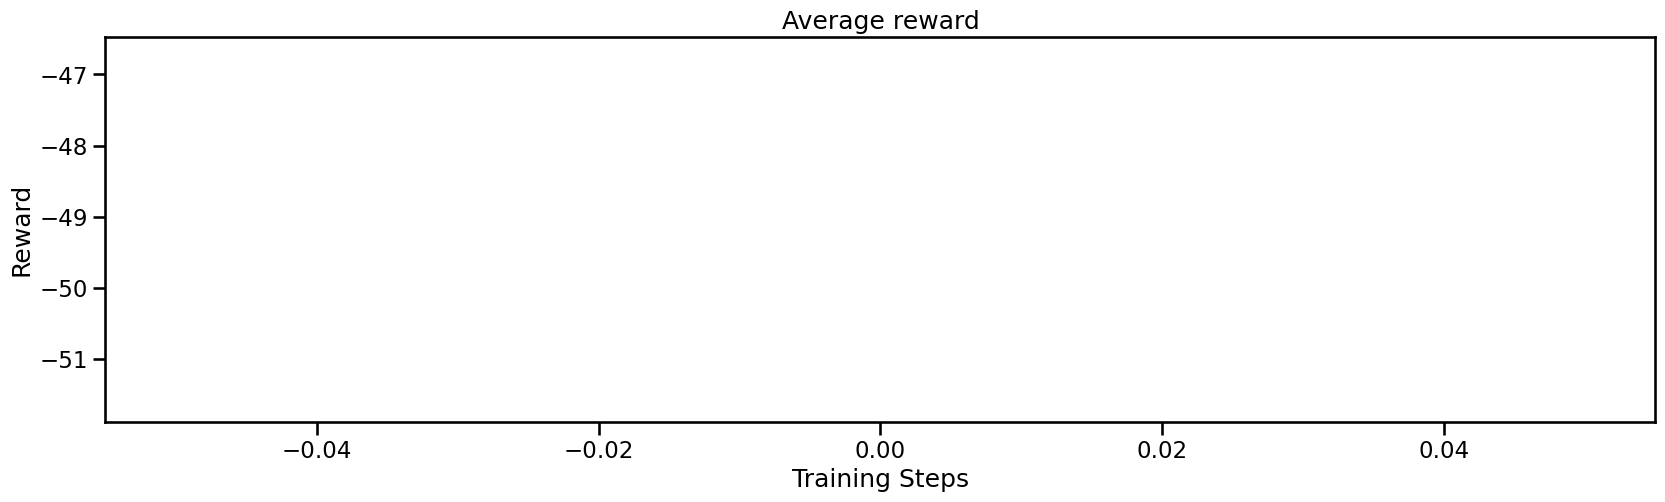

In [15]:
df = pd.DataFrame.from_dict(hist_dict, orient='index', columns=["score", "mu1", "mu2", "mu3", "mu4", "var1", "var2", "var3", "var4"])
ax = df.score.plot(title="Average reward", figsize=(20, 5))
plt.xlabel("Training Steps")
plt.ylabel("Reward")

Text(0.5, 0, 'Training Steps')

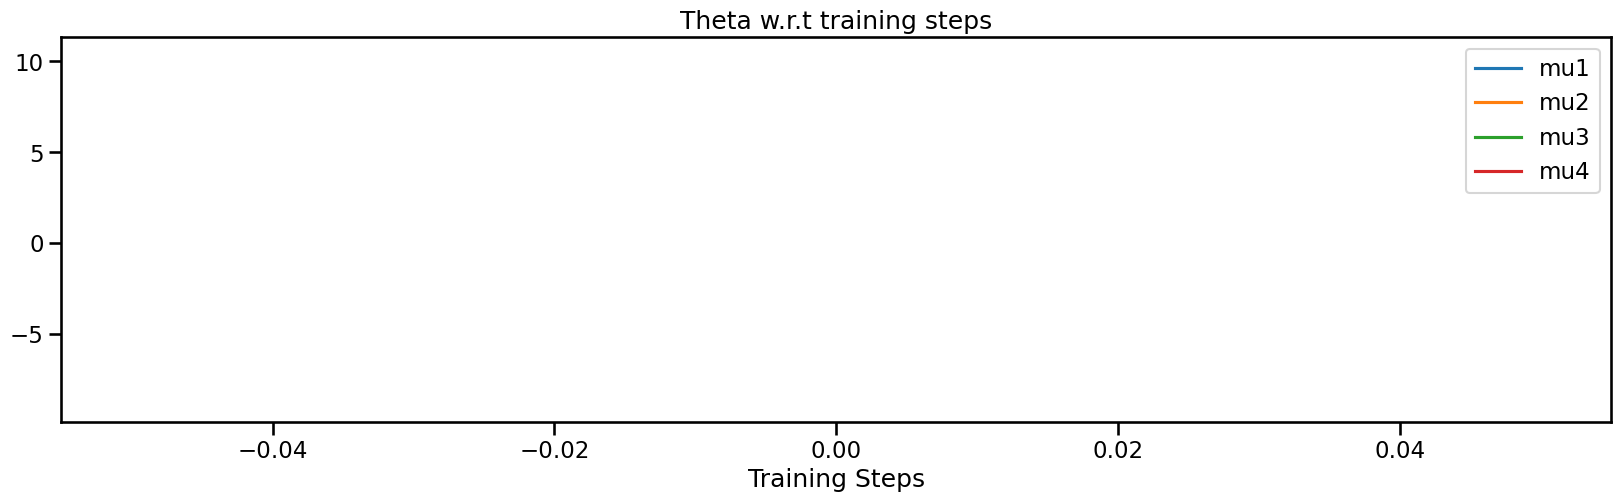

In [16]:
ax = df[["mu1", "mu2", "mu3", "mu4"]].plot(title="Theta w.r.t training steps", figsize=(20, 5))
plt.xlabel("Training Steps")

Text(0.5, 0, 'Training Steps')

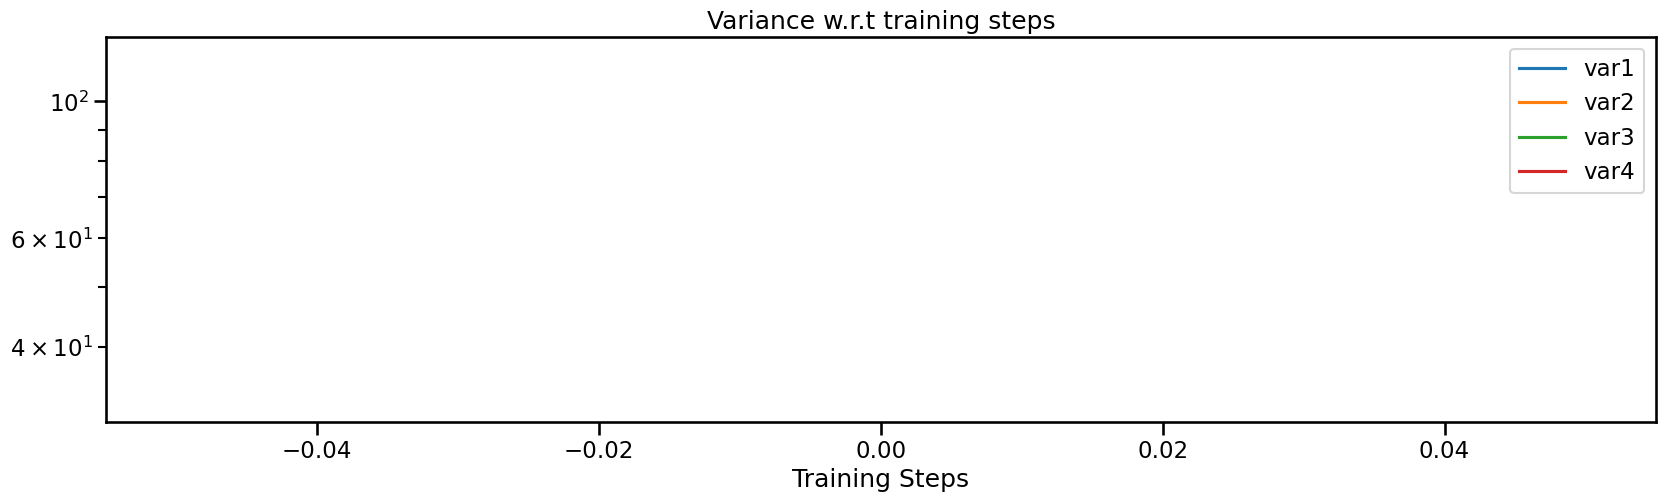

In [17]:
ax = df[["var1", "var2", "var3", "var4"]].plot(logy=True, title="Variance w.r.t training steps", figsize=(20, 5))
plt.xlabel("Training Steps")

In [18]:
print("Optimized weights: ", theta)

Optimized weights:  [-2.287787078941559, 10.373488122003826, -4.182285636935106, -8.87640369045862]


**Task 3:** test the optimized policy

Test Episode 0: Total Reward = 10.0
Test Episode 1: Total Reward = 10.0
Test Episode 2: Total Reward = 9.0


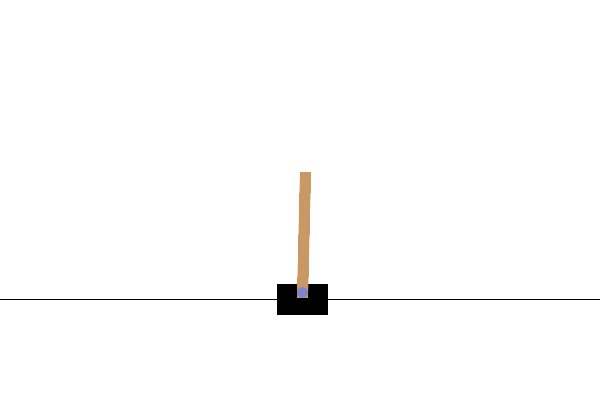

In [19]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
RenderWrapper.register(env, force_gif=True)

objective_function.eval(theta, num_episodes=3, max_time_steps=200, render=True)

objective_function.env.close()

objective_function.env.render_wrapper.make_gif("lab7_ex1_cem_cp")

## Exercise 2: implement SAES and solve the CartPole problem with it

**Task 1**: Implement the `saes_1_1` function that search the best $\theta$ parameters with a (1+1)-SA-ES algorithm. Use the objective function defined above.

**(1+1)-SA-ES**

**Input**:<br>
$\quad\quad$ $f$: the objective function<br>
$\quad\quad$ $\boldsymbol{x}$: initial solution<br>

**Algorithm parameter**:<br>
$\quad\quad$ $\tau$: self-adaptation learning rate<br>

**FOR EACH** generation<br>
$\quad\quad$ 1. mutation of $\sigma$ (current individual strategy) : $\sigma' \leftarrow \sigma ~ e^{\tau \mathcal{N}(0,1)}$<br>
$\quad\quad$ 2. mutation of $\boldsymbol{x}$ (current solution) : $\boldsymbol{x}' \leftarrow \boldsymbol{x} + \sigma' ~ \mathcal{N}(0,1)$<br>
$\quad\quad$ 3. eval $f(\boldsymbol{x}')$<br>
$\quad\quad$ 4. survivor selection $\boldsymbol{x} \leftarrow \boldsymbol{x}'$ and $\sigma \leftarrow \sigma'$ if $f(\boldsymbol{x}') \leq f(\boldsymbol{x})$<br>

**RETURN** $\boldsymbol{x}$

In [20]:
def saes_1_1(objective_function,
             x_array,
             sigma_array,
             max_iterations=500,
             tau=None,
             print_every=10,
             success_score=float("inf"),
             num_evals_for_stop=None,
             hist_dict=None):

    # TODO...
    for i_iteration in range(max_iterations):
        samples = np.random.multivariate_normal(x_array, np.diag(sigma_array), 2)
        scores = np.array([objective_function(samples[i]) for i in range(2)])

        if scores[0] > scores[1]:
            x_array = samples[0]
        else:
            x_array = samples[1]

        sigma_array = sigma_array * np.exp(tau * np.random.normal(0, 1, sigma_array.shape))

        if hist_dict is not None:
            # "score", "x1", "x2", "x3", "x4", "sigma1", "sigma2", "sigma3", "sigma4"
            hist_dict[i_iteration] = []
            hist_dict[i_iteration].append(scores.mean())
            hist_dict[i_iteration].append(x_array[0])
            hist_dict[i_iteration].append(x_array[1])
            hist_dict[i_iteration].append(x_array[2])
            hist_dict[i_iteration].append(x_array[3])
            hist_dict[i_iteration].append(sigma_array[0])
            hist_dict[i_iteration].append(sigma_array[1])
            hist_dict[i_iteration].append(sigma_array[2])
            hist_dict[i_iteration].append(sigma_array[3])

        if i_iteration % print_every == 0:
            print('Iteration {0}/{1}: mean score = {2}'.format(i_iteration, max_iterations, scores.mean()))

        if scores.mean() >= success_score:
            print('Success criterion reached!')
            break

        if num_evals_for_stop is not None and objective_function.num_evals >= num_evals_for_stop:
            print('Stop criterion reached!')
            break
    return x_array

**Task 2:** train your implementation using the following cells.

In [21]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
RenderWrapper.register(env, force_gif=True)

nn_policy = LogisticRegression(env)

objective_function = ObjectiveFunction(env=env,
                                       policy=nn_policy,
                                       num_episodes=10,
                                       max_time_steps=1000)

In [22]:
%%time

hist_dict = {}

initial_solution_array = np.random.random(nn_policy.num_params)
initial_sigma_array = np.ones(nn_policy.num_params) * 1.

theta = saes_1_1(objective_function=objective_function,
                 x_array=initial_solution_array,
                 sigma_array=initial_sigma_array,
                 tau = 0.001,
                 max_iterations=1000,
                 print_every=100,
                 success_score=-500,
                 num_evals_for_stop=None,
                 hist_dict=hist_dict)

objective_function.env.close()

Iteration 0/1000: mean score = -32.6
Success criterion reached!
CPU times: total: 15.6 ms
Wall time: 10.1 ms


Text(0, 0.5, 'Reward')

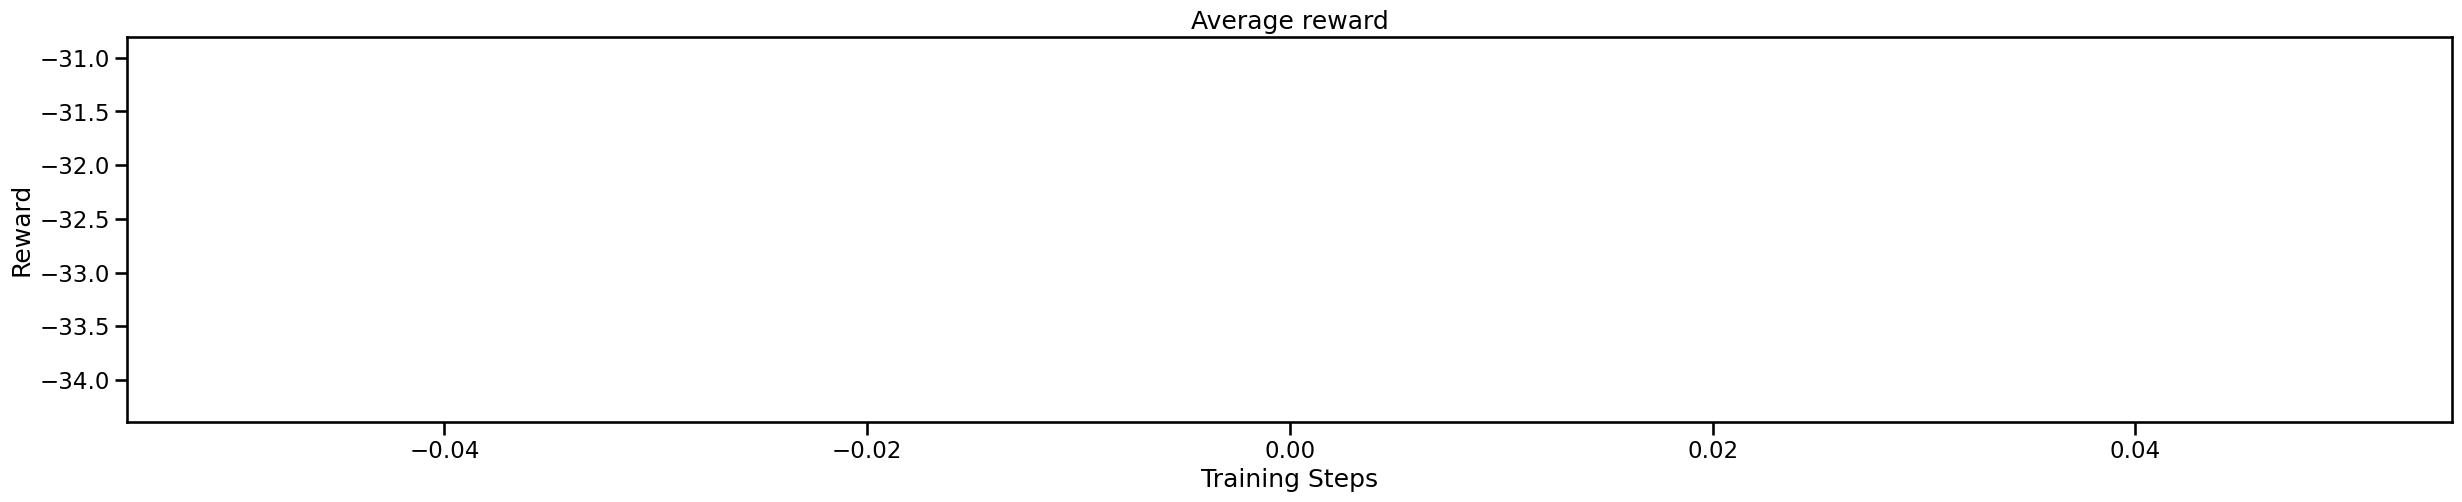

In [23]:
df = pd.DataFrame.from_dict(hist_dict, orient='index', columns=["score", "mu1", "mu2", "mu3", "mu4", "sigma1", "sigma2", "sigma3", "sigma4"])
ax = df.score.plot(title="Average reward", figsize=(30, 5));
plt.xlabel("Training Steps")
plt.ylabel("Reward")

Text(0.5, 0, 'Training Steps')

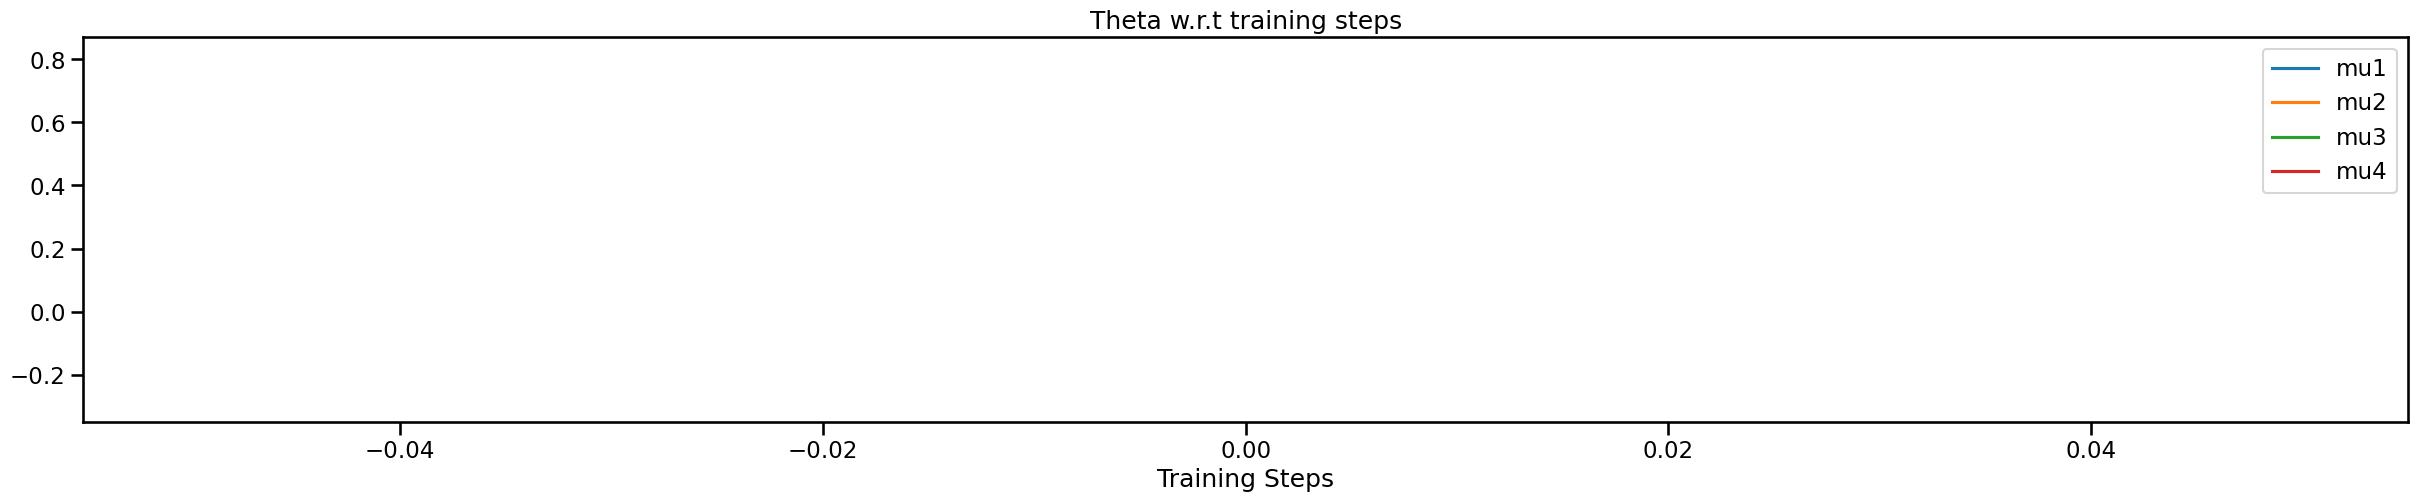

In [24]:
ax = df[["mu1", "mu2", "mu3", "mu4"]].plot(title="Theta w.r.t training steps", figsize=(30, 5));
plt.xlabel("Training Steps")

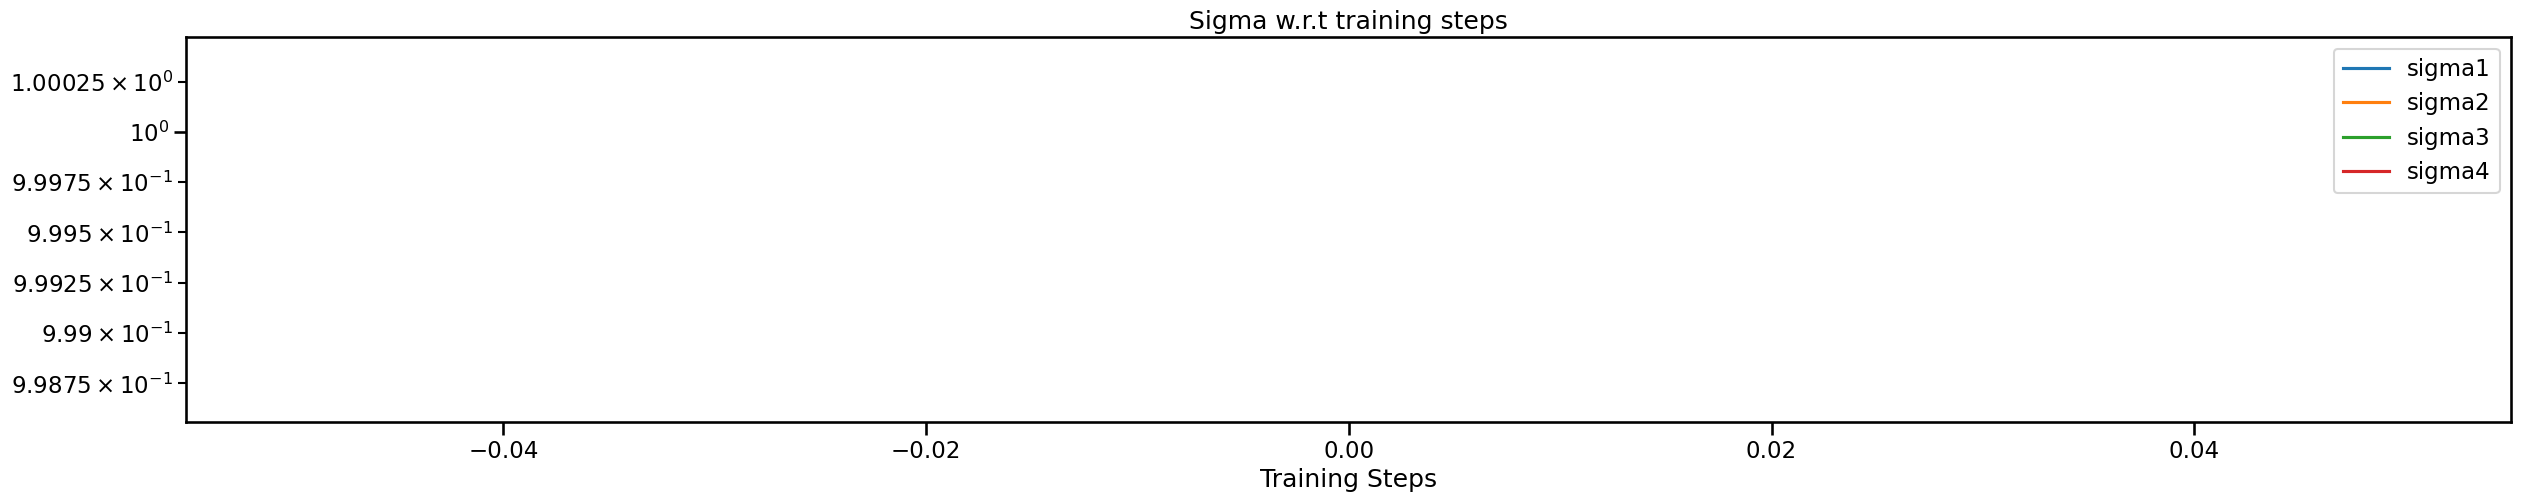

In [25]:
ax = df[["sigma1", "sigma2", "sigma3", "sigma4"]].plot(logy=True, title="Sigma w.r.t training steps", figsize=(30, 5))
plt.xlabel("Training Steps");

In [26]:
print("Optimized weights: ", theta)

Optimized weights:  [ 0.81496533 -0.04945947 -0.29463731  0.02134414]


**Task 3:** test the optimized policy

Test Episode 0: Total Reward = 22.0
Test Episode 1: Total Reward = 22.0
Test Episode 2: Total Reward = 15.0


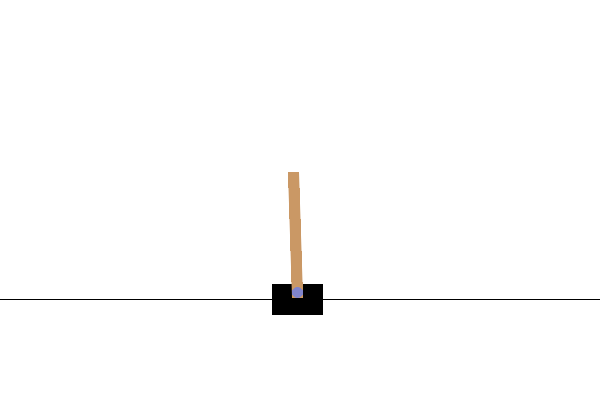

In [27]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
RenderWrapper.register(env, force_gif=True)

objective_function.eval(theta, num_episodes=3, max_time_steps=200, render=True)

objective_function.env.close()

objective_function.env.render_wrapper.make_gif("lab7_ex2_saes_cp")

**Task 4:** try different values of $\tau$. What happen ?

## Exercise 3: Implement a parametric policy $\pi_\theta$ for environments having a continuous action space

To solve problems having a continuous space, especially to solve the LunarLander problem in the next exercise, we need to define and implement an appropriate parametric policy.
For this purpose, we recommend the following neural network:
- one hidden layer of 16 units having a ReLu activation function
- a tanh activation function on the output layer (be careful on the number of output units)

To solve environments with continuous action space like LunarLander with Direct Policy Search methods, a simple procedure that compute the feed forward signal is needed (we don't do back propagation here).
A procedure to set/get weights of the network from/to a single vector $\theta$ will also be required.

In [30]:
# Activation functions ########################################################

def identity(x):
    return x

def tanh(x):
    return np.tanh(x)

def relu(x):
    x_and_zeros = np.array([x, np.zeros(x.shape)])
    return np.max(x_and_zeros, axis=0)

# Dense Multi-Layer Neural Network ############################################

class NeuralNetworkPolicy:

    def __init__(self, env, h_size=16):   # h_size = number of neurons on the hidden layer
        # Set the neural network activation functions (one function per layer)
        self.activation_functions = (relu, tanh)

        # Make a neural network with 1 hidden layer of `h_size` units
        weights = (np.zeros([env.observation_space.shape[0] + 1, h_size]),
                   np.zeros([h_size + 1, env.action_space.shape[0]]))

        self.shape_list = weights_shape(weights)
        print("Number of parameters per layer:", self.shape_list)

        self.num_params = len(flatten_weights(weights))
        print("Number of parameters (neural network weights) to optimize:", self.num_params)


    def __call__(self, state, theta):
        weights = unflatten_weights(theta, self.shape_list)

        return feed_forward(inputs=state,
                            weights=weights,
                            activation_functions=self.activation_functions)


def feed_forward(inputs, weights, activation_functions, verbose=False):

    # TODO...
    layer_output = inputs
    for layer_weights, activation_function in zip(weights, activation_functions):
        layer_output = np.dot(np.concatenate((layer_output, [1])), layer_weights)
        layer_output = activation_function(layer_output)
    return layer_output


def weights_shape(weights):
    return [weights_array.shape for weights_array in weights]


def flatten_weights(weights):
    """Convert weight parameters to a 1 dimension array (more convenient for optimization algorithms)"""
    nested_list = [weights_2d_array.flatten().tolist() for weights_2d_array in weights]
    flat_list = list(itertools.chain(*nested_list))
    return flat_list


def unflatten_weights(flat_list, shape_list):
    """The reverse function of `flatten_weights`"""
    length_list = [shape[0] * shape[1] for shape in shape_list]

    nested_list = []
    start_index = 0

    for length, shape in zip(length_list, shape_list):
        nested_list.append(np.array(flat_list[start_index:start_index+length]).reshape(shape))
        start_index += length

    return nested_list

## Exercise 4: solve the LunarLander problem (continuous version) with CEM and SAES

**Task 1:** read https://gymnasium.farama.org/environments/box2d/lunar_lander/ to discover the LunarLanderContinuous environment.

**Notice:** A reminder of Gymnasium main concepts is available at https://gymnasium.farama.org/content/basic_usage/.

Print some information about the environment:

In [31]:
env = gym.make("LunarLander-v2", continuous=True, render_mode="rgb_array")
print("State space dimension is:", env.observation_space.shape[0])
print("State upper bounds:", env.observation_space.high)
print("State lower bounds:", env.observation_space.low)
print("Actions upper bounds:", env.action_space.high)
print("Actions lower bounds:", env.action_space.low)
env.close()

DependencyNotInstalled: Box2D is not installed, run `pip install gymnasium[box2d]`

**Task 2:** Run the following cells and check different basic policies (for instance constant actions or randomly drawn actions) to discover the Lunar Lander environment.

In [ ]:
env = gym.make("LunarLander-v2", continuous=True, render_mode="rgb_array")
RenderWrapper.register(env, force_gif=True)

observation, info = env.reset()
done = False

for t in range(150):
    env.render_wrapper.render()

    #action = np.array([1., 1.])
    action = np.array([-1., -1.])
    #action = env.action_space.sample()   # Random policy

    observation, reward, done, truncated, info = env.step(action)

env.close()

env.render_wrapper.make_gif("lab7_ex4_explore")

**Question 1:** We want to use CEM and SAES to compute the optimal policy for the Lunar Lander environment.
What is the size of the search space (number of dimensions) for optimizers knowing that the policy is the one defined in exercise 3 (a neural network of one hidden layer of 16 neurons) and knowing that the State space of the Lunar Lander environment is $\mathcal{S} = \mathbb{R}^8$ and its action space is $\mathcal{A} \subset \mathbb{R}^2$ ?

# TODO...
 We want to use CEM and SAES to compute the optimal policy for the Lunar Lander environment.
What is the size of the search space (number of dimensions) for optimizers knowing that the policy is the one defined in exercise 3 (a neural network of one hidden layer of 16 neurons) and knowing that the State space of the Lunar Lander environment is $\mathcal{S} = \mathbb{R}^8$ and its action space is $\mathcal{A} \subset \mathbb{R}^2$ ?

The size of the search space is the number of parameters of the neural network. The neural network has one hidden layer of 16 neurons, so the number of parameters is the number of weights and biases of the input layer, the hidden layer and the output layer. The input layer has 8 neurons, the hidden layer has 16 neurons and the output layer has 2 neurons. The number of parameters is then:
$$8 \times 16 + 16 + 16 \times 2 + 2 = 130$$


**Task 3:** Train the agent using the CEM algorithm

In [ ]:
env = gym.make("LunarLander-v2", continuous=True, render_mode="rgb_array")
RenderWrapper.register(env, force_gif=True)

nn_policy = NeuralNetworkPolicy(env)

objective_function = ObjectiveFunction(env=env,
                                       policy=nn_policy,
                                       num_episodes=3,
                                       max_time_steps=500)

In [ ]:
%%time

hist_dict = {}

init_mean_array = np.random.random(nn_policy.num_params)
init_var_array = np.ones(nn_policy.num_params) * 1000.

theta = cem_uncorrelated(objective_function=objective_function,
                         mean_array=init_mean_array,
                         var_array=init_var_array,
                         max_iterations=100,
                         sample_size=50,
                         elite_frac=0.2,
                         print_every=1,
                         success_score=-200,
                         hist_dict=hist_dict)

objective_function.env.close()

In [ ]:
df = pd.DataFrame.from_dict(hist_dict, orient='index')
ax = df.iloc[:,0].plot(title="Average reward", figsize=(20, 5));
plt.xlabel("Training Steps")
plt.ylabel("Reward")

In [ ]:
ax = df.iloc[:,1:66].plot(title="Theta w.r.t training steps", legend=None, figsize=(20, 10))
#ax.get_legend().remove()
plt.xlabel("Training Steps");

In [ ]:
ax = df.iloc[:,67:].plot(logy=True, title="Variance w.r.t training steps", legend=None, figsize=(20, 10))
#ax.get_legend().remove()
plt.xlabel("Training Steps");

In [ ]:
print("Optimized weights: ", theta)

**Task 4:** check the optimized policy.

In [ ]:
env = gym.make("LunarLander-v2", continuous=True, render_mode="rgb_array")
RenderWrapper.register(env, force_gif=True)

objective_function.eval(theta, num_episodes=3, max_time_steps=500, render=True)

objective_function.env.close()

objective_function.env.render_wrapper.make_gif("lab7_ex4_cem_ll")

**Task 5:** Train the agent using the (1+1)-SA-ES algorithm

In [ ]:
env = gym.make("LunarLander-v2", continuous=True, render_mode="rgb_array")
RenderWrapper.register(env, force_gif=True)

nn_policy = NeuralNetworkPolicy(env)

objective_function = ObjectiveFunction(env=env,
                                       policy=nn_policy,
                                       num_episodes=5,
                                       max_time_steps=500)

In [ ]:
%%time

hist_dict = {}

initial_solution_array = np.random.random(nn_policy.num_params)
initial_sigma_array = np.ones(nn_policy.num_params) * 1.

theta = saes_1_1(objective_function=objective_function,
                 x_array=initial_solution_array,
                 sigma_array=initial_sigma_array,
                 max_iterations=1000,
                 print_every=10,
                 success_score=-200,
                 num_evals_for_stop=None,
                 hist_dict=hist_dict)

objective_function.env.close()

In [ ]:
df = pd.DataFrame.from_dict(hist_dict, orient='index')
ax = df.iloc[:,0].plot(title="Average reward", figsize=(20, 5));
plt.xlabel("Training Steps")
plt.ylabel("Reward")

In [ ]:
ax = df.iloc[:,1:66].plot(title="Theta w.r.t training steps", legend=None, figsize=(20, 10))
#ax.get_legend().remove()
plt.xlabel("Training Steps");

In [ ]:
ax = df.iloc[:,67:].plot(logy=True, title="Variance w.r.t training steps", legend=None, figsize=(20, 10))
#ax.get_legend().remove()
plt.xlabel("Training Steps");

In [ ]:
print("Optimized weights: ", theta)

**Task 6:** check the optimized policy.

In [ ]:
env = gym.make("LunarLander-v2", continuous=True, render_mode="rgb_array")
RenderWrapper.register(env, force_gif=True)

objective_function.eval(theta, num_episodes=3, max_time_steps=500, render=True)

objective_function.env.close()

objective_function.env.render_wrapper.make_gif("lab7_ex4_saes_ll")

## Bonus exercise 1: implement CEM with an alternative *Proposal distribution*

Implement CEM with the following alternative *Proposal distribution*: a multivariate normal distribution parametrized by a mean vector and **a covariance matrix** (to use correlations in the search space dimensions).

Test it on the CartPole and the LunarLander environments.

In [ ]:
def cem_correlated(objective_function,
                   mean_array,
                   var_array,
                   max_iterations=500,
                   sample_size=50,
                   elite_frac=0.2,
                   print_every=10,
                   success_score=float("inf"),
                   num_evals_for_stop=None,
                   hist_dict=None):
    """Cross-entropy method.

    Params
    ======
        objective_function (function): the function to maximize
        mean_array (array of floats): the initial proposal distribution (mean vector)
        var_array (array of floats): the initial proposal distribution (variance vector)
        max_iterations (int): number of training iterations
        sample_size (int): size of population at each iteration
        elite_frac (float): rate of top performers to use in update with elite_frac ∈ ]0;1]
        print_every (int): how often to print average score
        hist_dict (dict): logs
    """
    assert 0. < elite_frac <= 1.

    n_elite = math.ceil(sample_size * elite_frac)

    cov_array = np.diag(var_array)

    # TODO...

    return mean_array

### Test on CartPole

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
RenderWrapper.register(env, force_gif=True)

nn_policy = LogisticRegression(env)

objective_function = ObjectiveFunction(env=env,
                                       policy=nn_policy,
                                       num_episodes=10,
                                       max_time_steps=1000)

In [ ]:
%%time

hist_dict = {}

init_mean_array = np.random.random(nn_policy.num_params)
init_var_array = np.ones(nn_policy.num_params) * 100.

theta = cem_correlated(objective_function=objective_function,
                       mean_array=init_mean_array,
                       var_array=init_var_array,
                       max_iterations=30,
                       sample_size=50,
                       elite_frac=0.1,
                       print_every=1,
                       success_score=-500,
                       num_evals_for_stop=None,
                       hist_dict=hist_dict)

objective_function.env.close()

In [ ]:
df = pd.DataFrame.from_dict(hist_dict, orient='index', columns=["score"] + [f"mu{i}" for i in range(1,5)] + [f"cov{i}{j}" for i in range(1,5) for j in range(1,5)])
ax = df.score.plot(title="Average reward", figsize=(20, 5));
plt.xlabel("Training Steps")
plt.ylabel("Reward")

In [ ]:
ax = df[["mu1", "mu2", "mu3", "mu4"]].plot(title="Theta w.r.t training steps", figsize=(20, 5));
plt.xlabel("Training Steps")

In [ ]:
ax = df[[f"cov{i}{j}" for i in range(1,5) for j in range(1,5)]].plot(logy=True, title="Variance w.r.t training steps", figsize=(20, 5))
plt.xlabel("Training Steps");

In [ ]:
print("Optimized weights: ", theta)

## Bonus exercise 2: test the CMAES algorithm

PyCMA: Python implementation of CMA-ES (from Nikolaus Hansen - CMAP).

Source code:

- http://cma.gforge.inria.fr/cmaes_sourcecode_page.html#python
- https://github.com/CMA-ES/pycma
- https://pypi.org/project/cma/

Official documentation:

- http://cma.gforge.inria.fr/apidocs-pycma/

In [ ]:
import cma

In [ ]:
env = gym.make("LunarLander-v2", continuous=True, render_mode="rgb_array")
RenderWrapper.register(env, force_gif=True)

nn_policy = NeuralNetworkPolicy(env)

objective_function = ObjectiveFunction(env=env,
                                       policy=nn_policy,
                                       num_episodes=1,
                                       max_time_steps=500)

In [ ]:
%%time

x_optimal, es = cma.fmin2(objective_function, x0=np.random.random(nn_policy.num_params), sigma0=10., options={'maxfevals': 1500})
theta = x_optimal

In [ ]:
theta

In [ ]:
sns.set_context("talk")
plt.rcParams['figure.figsize'] = 20,10

cma.plot();  # shortcut for es.logger.plot()

Test the final policy

In [ ]:
objective_function.eval(theta, num_episodes=3, render=True)

objective_function.env.close()

objective_function.env.render_wrapper.make_gif("lab7_ex_pycma_ll")